# Imports

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Parameters

In [2]:
rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True
plt.rcParams["figure.autolayout"] = True

# Selfcoded functions

In [3]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

# Formula for Gaussian error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # for C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #for C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)+(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

# Results of the experiment
Important notes on the code conventions:
- Variable names use CamelCase and are abbreviated, e.g., lenseDistanceObject corresponds to the distance of the lens from the object.
- Errors are indicated in CamelCase with the suffix Err, e.g., distanceErr corresponds to the error of the distance variable.
- Units are commented after the values, e.g., x = 3 # mm or "vMax = 2 # V."

## Read lab data

In [4]:
intensitiesHg = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumHg.txt", usecols=1, skiprows=0, dtype='str')
#Hg = pd.read_csv("C:\\Users\\Pablo\\Documents\\FP\\Jod", sep=" ", header=None)
#intensitiesHg = Hg['946,18'].to_numpy()
intensitiesHg = np.char.replace(intensitiesHg, ',', '.').astype(float)
intensitiesHgErr = np.sqrt(intensitiesHg)
binsHg = np.arange(0, len(intensitiesHg), 1)
nBinsHg = len(binsHg)


intensitiesEmission = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumJodLED1Minute.txt", usecols=1, skiprows=0, dtype='str')
intensitiesEmission = np.char.replace(intensitiesEmission, ',', '.').astype(float)
intensitiesEmissionErr = np.sqrt(intensitiesEmission)
binsEmission = np.arange(0, len(intensitiesEmission), 1)
nBinsEmission = len(binsEmission)

intensitiesEmissionH = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumJodHA.txt", usecols=1, skiprows=0, dtype='str')
intensitiesEmissionH = np.char.replace(intensitiesEmissionH, ',', '.').astype(float)
intensitiesEmissionHErr = np.sqrt(intensitiesEmissionH)
binsEmissionH = np.arange(0, len(intensitiesEmissionH), 1)
nBinsEmissionH = len(binsEmissionH)

intensitiesNa = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumNA2.txt", usecols=1, skiprows=0, dtype='str')
intensitiesNa = np.char.replace(intensitiesNa, ',', '.').astype(float)
binsNa = np.arange(0, len(intensitiesNa), 1)
nBinsNa = len(binsNa)

intensitiesLED = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumLED.txt", usecols=1, skiprows=0, dtype='str')
intensitiesLED = np.char.replace(intensitiesLED, ',', '.').astype(float)
binsLED = np.arange(0, len(intensitiesLED), 1)
nBinsLED = len(binsLED)

intensitiesRed = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumRot.txt", usecols=1, skiprows=0, dtype='str')
intensitiesRed = np.char.replace(intensitiesRed, ',', '.').astype(float)
binsRed = np.arange(0, len(intensitiesRed), 1)
nBinsRed = len(binsRed)

intensitiesGreen = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumGrün.txt", usecols=1, skiprows=0, dtype='str')
intensitiesGreen = np.char.replace(intensitiesGreen, ',', '.').astype(float)
binsGreen = np.arange(0, len(intensitiesGreen), 1)
nBinsGreen = len(binsGreen)

intensitiesFluor = np.loadtxt("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod\\spektrumJodRed2.txt", usecols=1, skiprows=0, dtype='str')
intensitiesFluor = np.char.replace(intensitiesFluor, ',', '.').astype(float)
binsFluor = np.arange(0, len(intensitiesFluor), 1)
nBinsFluor = len(binsFluor)

## Plot lab data

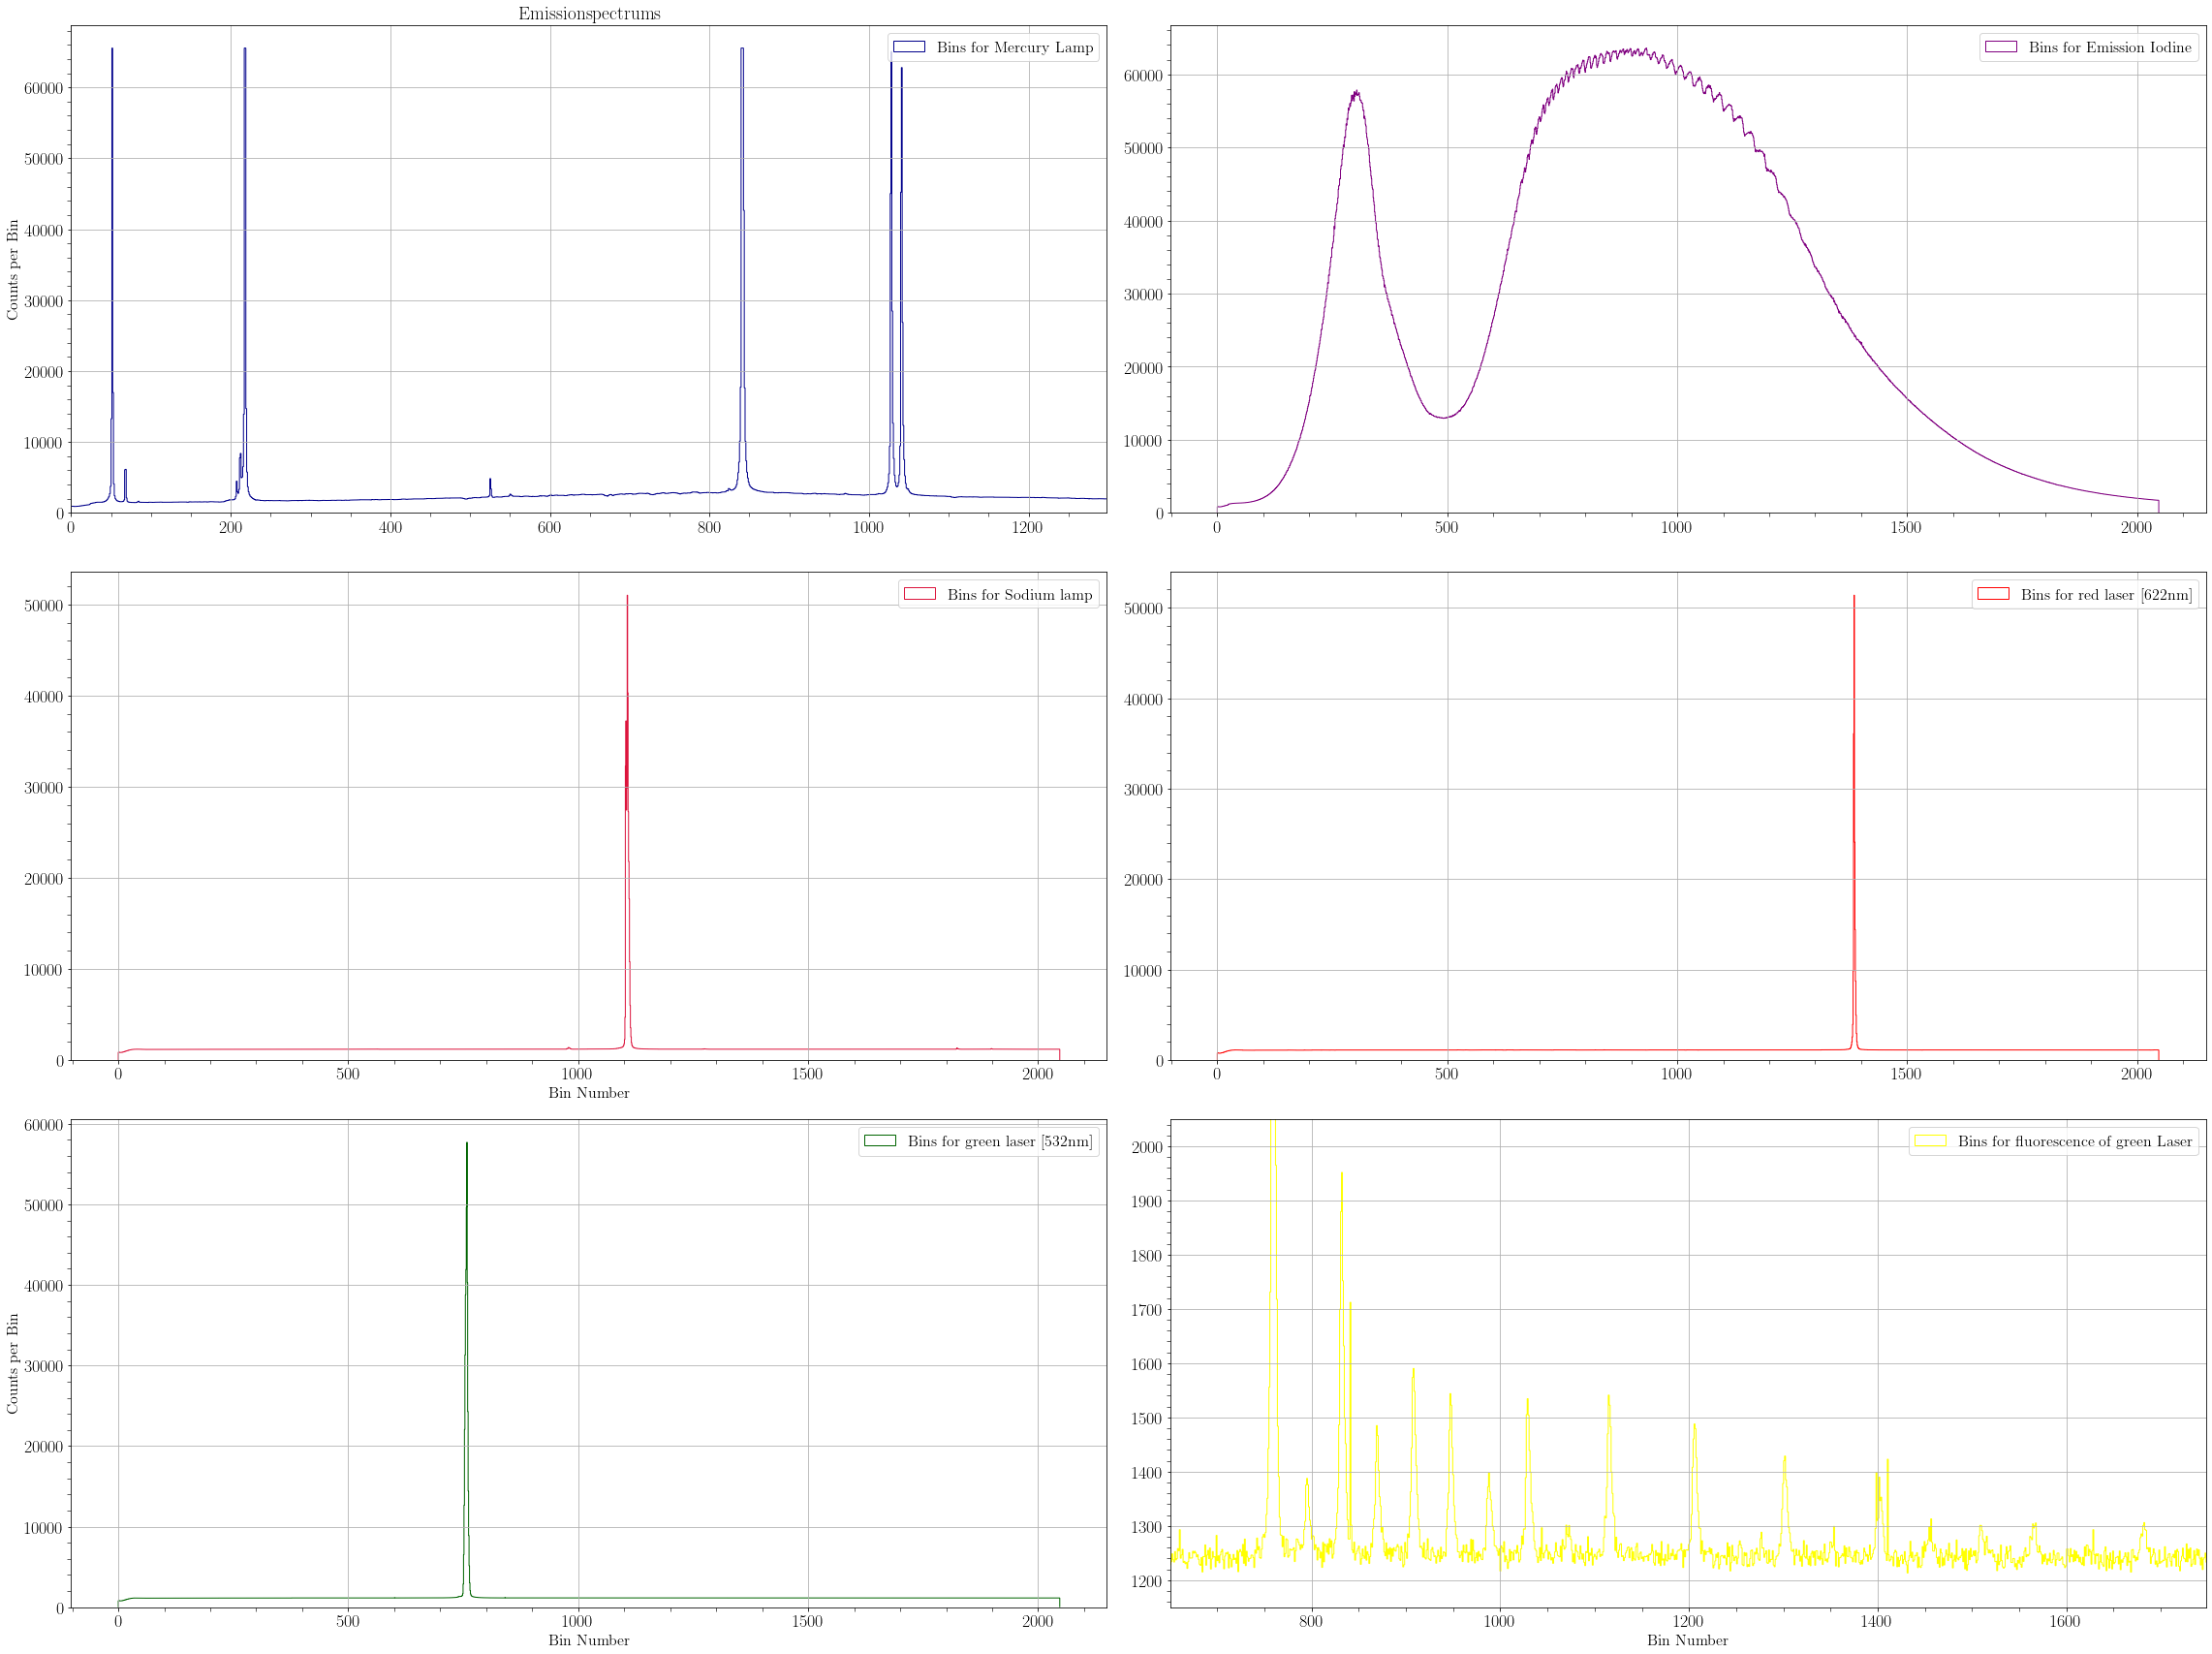

In [5]:


fig, ax = plt.subplots(3, 2, sharex=False, figsize=(32, 24))

ax[0 ,0].hist(binsHg, bins=nBinsHg, histtype='step', color='darkblue', 
           weights=intensitiesHg, label=r'Bins for Mercury Lamp')

ax[0, 0].set_xlim([0, nBinsHg-750])

ax[1, 0].hist(binsNa, bins=nBinsNa, histtype='step', color='crimson', 
           weights=intensitiesNa, label=r'Bins for Sodium lamp')
#ax[1, 0].set_xlim([0, nBins])
#ax[1, 0].set_yscale('log')

ax[0, 1].hist(binsEmission, bins=nBinsEmission, histtype='step', color='purple', 
               weights=intensitiesEmission, label=r'Bins for Emission Iodine')
#ax[0, 1].set_xlim([0, nBins])
#ax[0, 1].set_yscale('log')

ax[1, 1].hist(binsRed, bins=nBinsRed, histtype='step', color='red', 
           weights=intensitiesRed, label=r'Bins for red laser [622nm]')
#ax[1, 1].set_xlim([0, nBins])
#ax[1, 1].set_yscale('log')

ax[2, 0].hist(binsGreen, bins=nBinsGreen, histtype='step', color='darkgreen', 
           weights=intensitiesGreen, label=r'Bins for green laser [532nm]')

ax[2, 1].hist(binsFluor, bins=nBinsFluor, histtype='step', color='yellow', 
           weights=intensitiesFluor, label=r'Bins for fluorescence of green Laser')

ax[2, 1].set_xlim([650, nBinsFluor-300])
ax[2, 1].set_ylim([1150, 2050])
#ax[1, 1].set_yscale('log')

ax[0, 0].set(title=r'Emissionspectrums')
ax[0, 0].set(ylabel=r'Counts per Bin')
ax[1, 0].set(xlabel=r'Bin Number')
ax[2, 0].set(xlabel=r'Bin Number', ylabel=r'Counts per Bin')
ax[2, 1].set(xlabel=r'Bin Number')


ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
ax[2, 1].legend()

#fig.savefig("Kalibratrionsspektren.pdf")

## Calibration
Calibration was realized via measuring the known spectrums of the two (Na and Hg) calibration lamps. The data from these measurements was used to couple the bin numbers of peaks with the wavelengths of the corresponding known emission peaks and  linear regression was performed over all the points.

### Get calibration parameters via linear regression

(8,)
451.12743900139077
637.4712450362988
529.059328142384
637.6444270121676


<ipython-input-6-633ff99ed4db>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


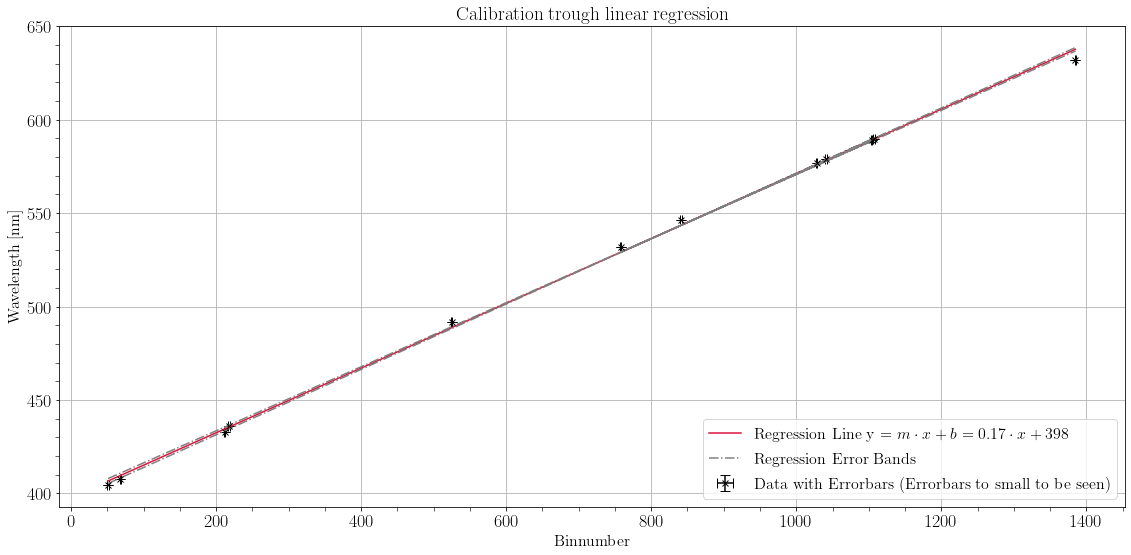

In [6]:
binNumbersHg = np.array([51, 68, 212, 218, 525, 841, 1028, 1041]) 
binNumbersNa = np.array([1104, 1107]) 
binNumbersLaser = np.array([intensitiesGreen.argmax(), intensitiesRed.argmax()])
#binNumberLED = np.array()

print(binNumbersHg.shape)
# Source: Typical spectra of Oriel Spectral Lamps Oriel Optics Corporation 1 Market Street Stamford connecticut 06902
# Figure 36 & 35
wavelengthsHg = np.array([404.6, 407.78, 432.92, 435.84, 491.60, 546.07, 576.96, 579.07]) # nm 
wavelengthsNa = np.array([589.0, 589.6]) # nm
wavelengthsLaser = np.array([532.0, 632.0])


binNumbers = np.concatenate((binNumbersHg, binNumbersNa, binNumbersLaser))
binErr = 1
wavelengths = np.concatenate((wavelengthsHg, wavelengthsNa, wavelengthsLaser))

m = bestM(binNumbers, wavelengths)
b = bestB(binNumbers, wavelengths)
mErr = stuM(binNumbers, wavelengths)
bErr = stuB(binNumbers, wavelengths)

# Adjust plot size
fig, ax = plt.subplots(figsize=(16, 8))

#plt.figure(figsize=(16, 8))    

# Draw the Datapoints
# yerr = 0 because literature values
ax.errorbar(binNumbers, wavelengths, xerr=binErr,
             yerr=0, fmt='x', capsize=5, label='Data with Errorbars (Errorbars to small to be seen)', color='black')

# Draw the regression curve
ax.plot(binNumbers, m * binNumbers + b, color='crimson', 
         label=f'Regression Line y = $m\cdot x + b = {m:.2f}\cdot x + {b:.0f}$')

ax.plot(binNumbers, (m + mErr)* binNumbers - bErr + b, color='gray', ls='-.',
         label=f'Regression Error Bands')
ax.plot(binNumbers, (m - mErr)* binNumbers + bErr + b, color='gray', ls='-.')

# Axislabels
ax.set_xlabel(r'Binnumber')
ax.set_ylabel(r'Wavelength [nm]')
ax.set_title("Calibration trough linear regression")

ax.legend(loc=4)
fig.show()

print(308*m+b) # 450
print(1384*m+b) # 632

print(intensitiesGreen.argmax()*m+b) # should be 522 nm
print(intensitiesRed.argmax()*m+b) # should be 632 nm
#while True:
#    eingabe = int(input("Angezeigte Wellenlänge: "))
#    print("Echte Wellenlänge",eingabe,"-->",eingabe*m+b)


### Use Calibration parameters to calculate and plot accurate emission spectrum:

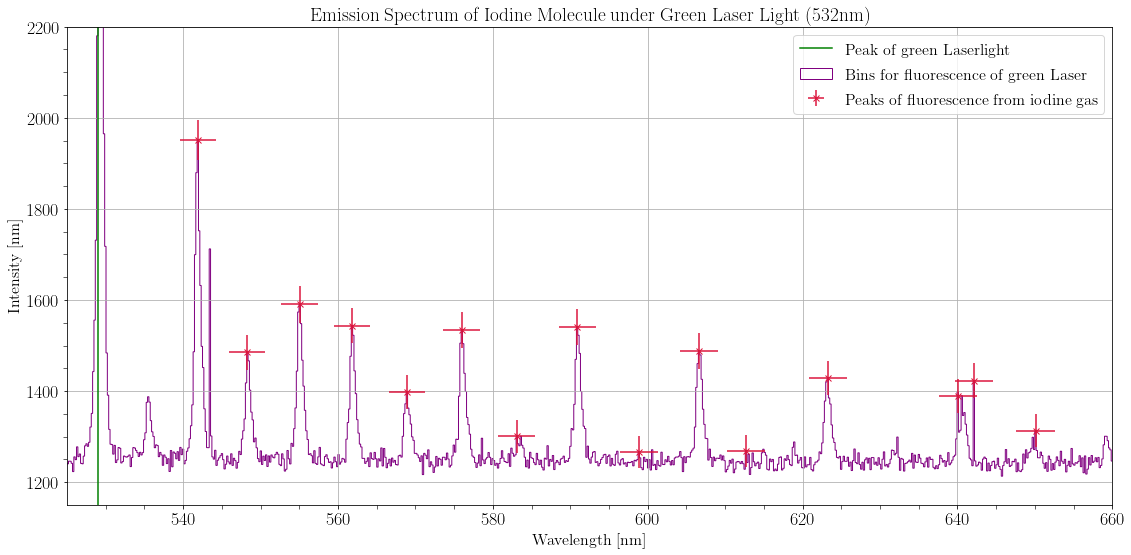

[541.87479436 548.28252746 555.03662452 561.79072158 568.89118259
 575.9916436  583.09210461 590.88529353 598.85166442 606.64485333
 612.70622249 623.27032302 640.06897467 642.14715838 650.11352927]


In [24]:
binsFluorCal = binsFluor*m+b
binsFluorCalErr = binsFluor*mErr+bErr

# Adjust plot size
plt.figure(figsize=(16, 8))    

plt.axvline(x=529.059, color='green', label=r'Peak of green Laserlight')

# Draw the Datapoints
plt.hist(binsFluorCal, bins=nBinsFluor, histtype='step', color='purple', 
           weights=intensitiesFluor, label=r'Bins for fluorescence of green Laser')

peaksFluor = np.array([832, 869, 908, 947, 988, 1029, 1070, 1115, 1161, 1206, 1241, 1302, 1399, 1411, 1457]) # 1404  
peaksFluorIntensities = np.array([1951.54, 1484.84, 1590.16, 1543.82, 1398.00, 1534.46, 1300.64, 1541.01, 
                                  1265.76, 1487.88, 1268.8, 1428.66, 1389.81, 1422.81, 1312.81]) # 1352.83
peaksFluorIntensitiesErr = np.sqrt(peaksFluorIntensities)

nPeaksFluor = len(peaksFluor)
peaksFluorCal = peaksFluor*m+b
peaksFluorCalErr = peaksFluorCal*mErr+bErr

plt.errorbar(peaksFluorCal, peaksFluorIntensities, xerr=peaksFluorCalErr, yerr=peaksFluorIntensitiesErr, color='crimson', fmt='x',
         label=r'Peaks of fluorescence from iodine gas')

plt.xlim([525, 660])
plt.ylim([1150, 2200])

# Axislabels
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'Intensity [nm]')
plt.title("Emission Spectrum of Iodine Molecule under Green Laser Light (532nm)")

plt.legend()
plt.show()

print(peaksFluorCal)

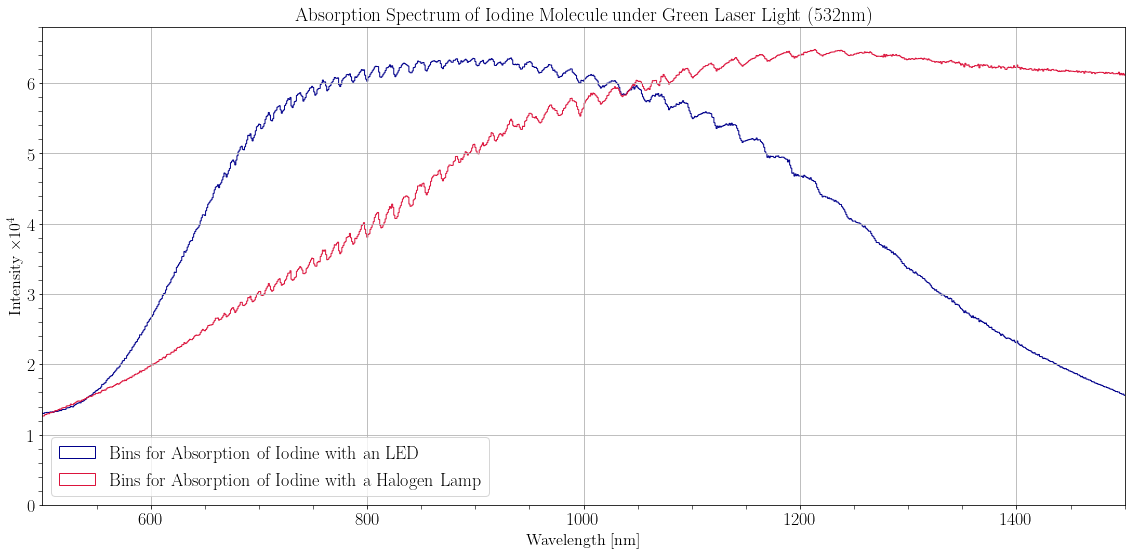

In [8]:
plt.figure(figsize=(16, 8))   


plt.hist(binsEmission, bins=nBinsEmission, histtype='step', color='darkblue', 
               weights=intensitiesEmission/10000, label=r'Bins for Absorption of Iodine with an LED')

plt.hist(binsEmissionH, bins=nBinsEmissionH, histtype='step', color='crimson', 
               weights=intensitiesEmissionH/10000, label=r'Bins for Absorption of Iodine with a Halogen Lamp')

plt.xlim([500, 1500])

plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'Intensity $ \times 10^{4}$')
plt.title("Absorption Spectrum of Iodine Molecule under Green Laser Light (532nm)")

plt.legend(loc=3, fontsize=18)
plt.show()

15


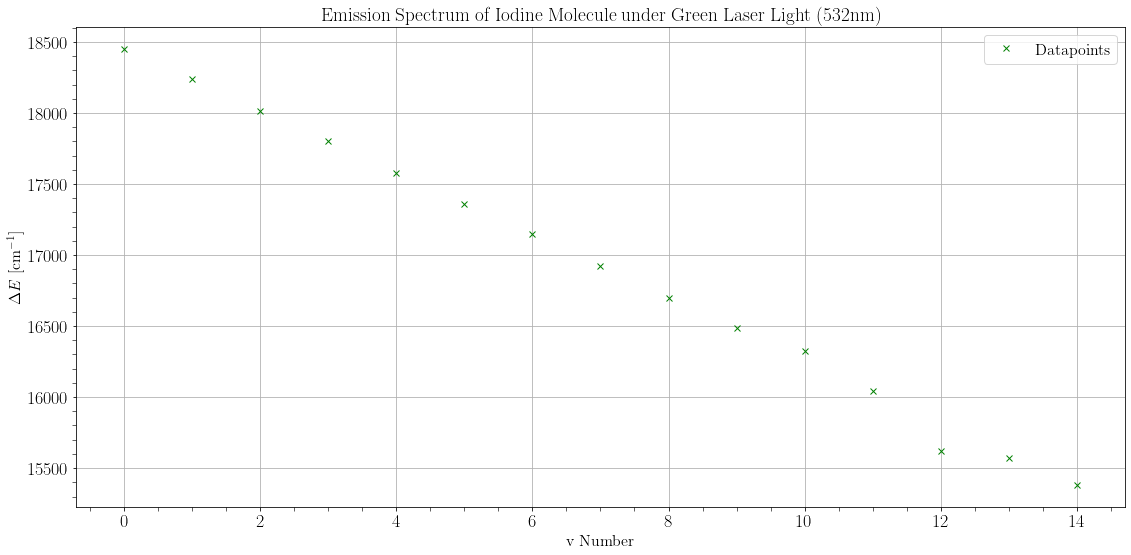

In [25]:
energy = (1/peaksFluorCal)*1e7

print(len(peaksFluorCal))
vibrationalN = np.arange(0, len(peaksFluorCal), 1)

# Adjust plot size
plt.figure(figsize=(16, 8))    

# Draw the Datapoints
plt.errorbar(vibrationalN, energy, color='green', fmt='x', label=r'Datapoints')

# Axislabels
plt.xlabel(r'v Number')
plt.ylabel(r'$\Delta E$ [cm$^{-1}$]')
plt.title("Emission Spectrum of Iodine Molecule under Green Laser Light (532nm)")

plt.legend()
plt.show()